# ASCE 41-17 Tier 1 Screening
This notebook is for carrying out Tier 1 checks to ASCE 41-17.

## Utilities

In [1]:
from math import log, log10, pi, sin, cos, tan, acos, asin, atan, atan2
from itertools import accumulate
#from ASCE41_17 import printt, interp, list_interp, k_gen, storey_force_coeffs, storey_force_distribution, storey_forces, storey_shear_moment, shear_coords
from ASCE41_17 import k_gen, storey_force_coeffs, storey_force_distribution, storey_forces, storey_shear_moment, shear_coords
#from ASCE41_17 import T_code_get, site_coeffs
from ASCE41_17 import site_coeffs, B_1_func, C_t_get, beta_get, T_code_get, S_a_func, ASCE41_17_tripartite_plot, ASCE41_17_plots

# For reloading custom libraries when they are changed
%load_ext autoreload
#%reload_ext autoreload
%autoreload 2
%aimport -matplotlib -pandas -numpy -bokeh -math - itertools

## Building Specific
Read data from CSV file into the notebook. 

Currently this notebook assumes that storeys and relevant data will be imported in the followng format:
> name, storey height (m), elevation (m), mass (kg)

It is also assumed that response spectrum input will be imported as (period (s), acceleration(g)) pairs 

e.g. 'WismaMC.csv'

In [2]:
from itertools import accumulate
from csv import reader, excel_tab
from tkinter import filedialog
from tkinter import *

filepath = "C:/Users/andrew.mole/OneDrive - Arup/Source/JupyterSamples/pySeismic/WismaMC.csv"

if filepath is None:
    root = Tk()
    root.filename =  filedialog.askopenfilename(initialdir = "/",title = "Select file",filetypes = (("csv files","*.csv"),("all files","*.*")))
    filepath = root.filename
    root.destroy()

print(f'File path is "{filepath}"')


File path is "C:/Users/andrew.mole/OneDrive - Arup/Source/JupyterSamples/pySeismic/WismaMC.csv"


In [3]:
with open(filepath, newline='') as csvfile:
    csv_reader = reader(csvfile, dialect = 'excel')
    data = [r for r in csv_reader]
storey_data = [[a, float(b), float(c), float(d)] for a,b,c,d in data]

## Storey Geometrical & Load Data

In [4]:
#g_m_s_2 = 9.80665
g_m_s_2 = 9.81
storey_names, storey_heights_m, storey_elevs_m, storey_masses_kg  = zip(*storey_data)
storey_weights_kN = [g_m_s_2 * 0.001 * float(m) for m in storey_masses_kg]

height_m = max(storey_elevs_m)

total_mass_tonne = 0.001 * sum(storey_masses_kg)
total_weight_kN = sum(storey_weights_kN)

basic_f = 'Height is {:.2f}m, total mass is {:8,.0f} tonne, total weight is {:8,.0f} kN\n'
print(basic_f.format(height_m, total_mass_tonne, total_weight_kN))

tit_f = '{:20s} {:9s} {:10s} {:10s} {:10s}'
print(tit_f.format('Storey', 'Ht. (m)', 'Elev (m)', 'Mass (kg)', 'Weight (kN)'))
num_f = '{:20s} {:6.3f}   {:8.3f}   {:>10,.0f}   {:8,.0f}'
[print(num_f.format(n, h, e, m, w)) for n, h, e, m, w in zip(storey_names, storey_heights_m, 
                                                 storey_elevs_m, storey_masses_kg, storey_weights_kN)];


Height is 104.83m, total mass is   76,634 tonne, total weight is  751,776 kN

Storey               Ht. (m)   Elev (m)   Mass (kg)  Weight (kN)
Roof                  7.470    104.830    2,324,712     22,805
Mechanical Floor      3.510     97.360    2,902,933     28,478
L22                   3.810     93.850    2,141,705     21,010
L21                   3.510     90.040    1,441,675     14,143
L20                   3.510     86.530    1,443,172     14,158
L19                   3.510     83.020    1,443,172     14,158
L18                   3.510     79.510    1,443,172     14,158
L17                   3.510     76.000    1,516,156     14,873
L16                   3.510     72.490    1,535,830     15,066
L15                   3.510     68.980    1,542,891     15,136
L14                   3.510     65.470    1,468,952     14,410
L13                   3.510     61.960    1,529,322     15,003
L12                   3.510     58.450    1,649,770     16,184
L11                   3.510     54.940

## Seismic Hazard

In [5]:
# Site Spectral Accelerations
S_s = 0.11267  # g
S_1 = 0.03767  # g

# Structural Type
s_type = 'C2'
site_class = 'D'
F_a, F_v = site_coeffs(site_class, S_s, S_1)

print('Site coeffs F_a ({}), F_v ({}) for site class {}'.format(F_a, F_v, site_class))

# Effective Viscous Damping Ratio
beta = 0.05  # standard value is 5% (0.05)
B1 = B_1_func(beta)

print('Damping ratio is {} and B1 is {:.2f}'.format(beta, B1))

# Dynamic Properties (empirical)
C_t = C_t_get(s_type)
beta = beta_get(s_type)
T_code_s = T_code_get(s_type, height_m)
k = k_gen(T_code_s)

per_f = 'Code period is {:.3f} sec, k is {:.2f} (C_t is {:.3f}, beta is {:.3f}, height is {:.3f}m)'
print(per_f.format(T_code_s, k, C_t, beta, height_m))

S_a_g = S_a_func(T_code_s, S_s, S_1, site_class)
S_v_g = 0.5 / pi * T_code_s *  S_a_g * 9.81  # in m/s
S_d_g = 0.5 / pi * T_code_s *  S_v_g  # in m


print('Period is {:.3f}sec,  Spectral Acceleration is {:.4f}g'.format(T_code_s, S_a_g)) ;

Site coeffs F_a (1.6), F_v (2.4) for site class D
Damping ratio is 0.05 and B1 is 1.00
Code period is 1.597 sec, k is 1.55 (C_t is 0.020, beta is 0.750, height is 104.830m)
Period is 1.597sec,  Spectral Acceleration is 0.0566g


In [6]:
from time import sleep
import matplotlib.pyplot as plt
%matplotlib --list
sleep(2)

Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'wx', 'qt4', 'qt5', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']


In [7]:
#%matplotlib notebook
%matplotlib inline

In [8]:
T_max = max(3.0, 1.2 * T_code_s)
lim = round(T_max * 100) + 1
T_range = [0.01 * float(T) for T in range(1,lim)]

soil_classes = ['A', 'B', 'C', 'D', 'E']
S_a_ranges = [[S_a_func(T, S_s, S_1, s_c) for T in T_range] for s_c in soil_classes]
S_v_ranges = [[9.81 * 0.5 / pi * T * S_a for T, S_a in zip(T_range, S_a_range)] for S_a_range in S_a_ranges]
S_d_ranges = [[0.5 / pi * T * S_v for T, S_v in zip(T_range, S_v_range)] for S_v_range in S_v_ranges]

figs, (ax1,ax2,ax3, ax4) = plt.subplots(4,figsize = (10,15))

[ax1.plot(T_range, S_a_range, label=s_c) for s_c, S_a_range in zip(soil_classes, S_a_ranges)]
ax1.plot(T_code_s, S_a_g, marker = 'o')
ax1.grid(True)
ax1.legend(soil_classes)

[ax2.plot(T_range, S_v_range, label=s_c) for s_c, S_v_range in zip(soil_classes, S_v_ranges)]
ax2.plot(T_code_s, S_v_g, marker = 'o')
ax2.grid(True)
ax2.legend(soil_classes)

[ax3.plot(T_range, S_d_range, label=s_c) for s_c, S_d_range in zip(soil_classes, S_d_ranges)]
ax3.plot(T_code_s, S_d_g, marker = 'o')
ax3.grid(True)
ax3.legend(soil_classes)

[ax4.plot(S_d_range, S_a_range, label=s_c) for s_c, S_d_range, S_a_range in zip(soil_classes, S_d_ranges, S_a_ranges)]
ax4.plot(S_d_g, S_a_g, marker = 'o')
ax4.grid(True)
ax4.legend(soil_classes)

#fig1.set_size_inches(16,8)
#figs.show()  # not needed in a Jupyter Notebook

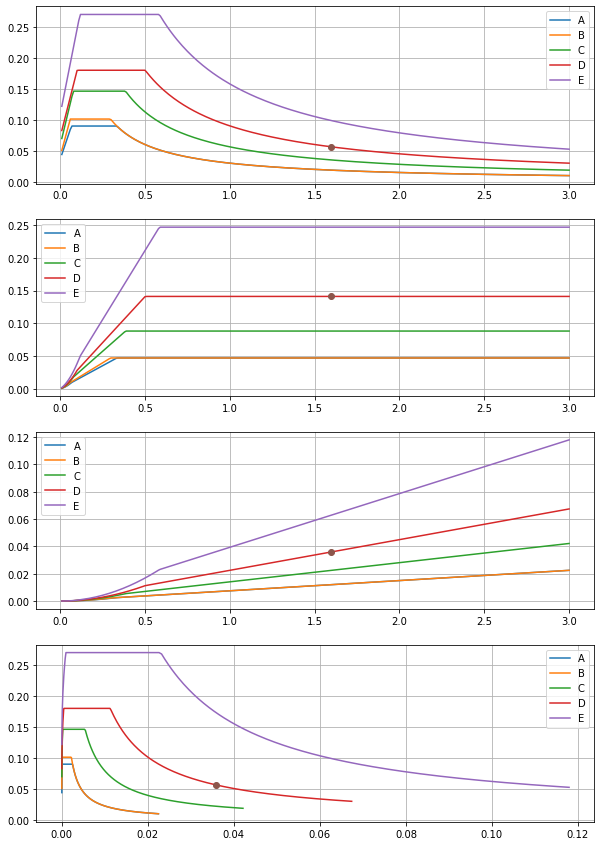

In [9]:
# tuple(zip(T_range, S_a_ranges[4]))

## Storey Force Data
This relies on the data calculated previously. It is therefore important that the cells below be recalculated if changes are made above here.

In [10]:
# 
print('Structural Type is {}'.format(s_type))

W_kN = total_weight_kN
V_kN = S_a_g * W_kN
print('Base shear is {:,.0f} kN  (S_a is {:,.4f}g, W is {:,.0f}kN)\n'.format(V_kN, S_a_g, W_kN))

storey_force_coeff_list = storey_force_coeffs(storey_elevs_m, storey_weights_kN, k)
storey_loads_kN = storey_force_distribution(V_kN, storey_elevs_m, storey_weights_kN, k)

storey_shears_kN, storey_moments_kNm = storey_shear_moment(storey_loads_kN, storey_heights_m, False)

tit_f = '{:20s} {:9s} {:10s} {:10s} {:10s} {:10s} {:10s}'
print(tit_f.format('Storey', 'Elevs (m)', 'Weights (kN)', ' Coeffs ', 'Forces (kN)', 'Shears (kN)', 'Moments (kNm)'))
num_f = '{:20s} {:8.2f}   {:8,.0f}   {:8.4f}   {:8,.0f}   {:>10,.0f}   {:>10,.0f}'
[print(num_f.format(n, h, wt, c, f, s, m)) for n, h, wt, c, f, s, m in zip(storey_names, storey_elevs_m, storey_weights_kN, 
                           storey_force_coeff_list, storey_loads_kN, storey_shears_kN, storey_moments_kNm)];


Structural Type is C2
Base shear is 42,551 kN  (S_a is 0.0566g, W is 751,776kN)

Storey               Elevs (m) Weights (kN)  Coeffs    Forces (kN) Shears (kN) Moments (kNm)
Roof                   104.83     22,805     0.1106      4,707        4,707            0
Mechanical Floor        97.36     28,478     0.1232      5,242        9,948       35,159
L22                     93.85     21,010     0.0859      3,653       13,602       70,078
L21                     90.04     14,143     0.0542      2,306       15,908      121,901
L20                     86.53     14,158     0.0510      2,171       18,079      177,739
L19                     83.02     14,158     0.0478      2,036       20,115      241,196
L18                     79.51     14,158     0.0448      1,904       22,019      311,800
L17                     76.00     14,873     0.0438      1,865       23,885      389,088
L16                     72.49     15,066     0.0413      1,756       25,641      472,924
L15                     6

## Assessment

Building Types:
C1
C2

In [11]:
# Default Values
f_c_psi = 4000.0 # MPa table 4-2
f_y_ksi = 52 # MPa table 4-3
F_y = 24 # ksi table 4-4 & 4-5
E_s = 200.0  # GPa 
F_pe = 111.2 # kN 

### Tripartite Plot

In [12]:
# T_max = max(3.0, 1.2 * T_code_s)
T_max = 3.0
lim = round(T_max * 100) + 1
T_range = [0.01 * float(T) for T in range(1,lim) if 0.01 * float(T) >= 0.1]

#S_a_g = S_a_func(T_code_s, S_s, S_1, site_class)
#S_v_g = 0.5 / pi * T_code_s *  S_a_g * 9.81  # in m/s

soil_classes = ['A', 'B', 'C', 'D', 'E']
S_a_ranges = [[S_a_func(T, S_s, S_1, s_c) for T in T_range] for s_c in soil_classes]
S_v_ranges = [[9.81 * 0.5 / pi * T * S_a for T, S_a in zip(T_range, S_a_range)] for S_a_range in S_a_ranges]

In [13]:
import matplotlib.lines as lines

fig0, ax0 = plt.subplots(figsize = (10,8))
[ax0.loglog(T_range, S_v_range, label=s_c) for s_c, S_v_range in zip(soil_classes, S_v_ranges)]
# ax0.loglog(T_code_s, S_v_g, marker = 'o') # marking the results for the building period

ax0.grid(True)
#fig = plt.gcf(); fig.set_size_inches(16,8)
ax0.legend(soil_classes)

##### Tripartite Lines ###########
x0 = fig0.axes[0].get_xlim() ; print(x0)
y0 = fig0.axes[0].get_ylim() ; print(y0)

T_min, T_max = x0  
log_T_min, log_T_max = log10(T_min), log10(T_max)
print('T_min, T_max', T_min, T_max)

v_min, v_max = y0  
log_v_min, log_v_max = log10(v_min), log10(v_max)
print('v_min, v_max', v_min, v_max)

a_min, a_max = [2.0 * pi / T * v for v, T in ((v_min, T_max),(v_max, T_min))]
log_a_min, log_a_max = log10(a_min), log10(a_max)
print('a_min, a_max', a_min, a_max)

d_min, d_max = [0.5 / pi * T * v for v, T in ((v_min, T_min),(v_max, T_max))]
log_d_min, log_d_max = log10(d_min), log10(d_max)
print('d_min, d_max', d_min, d_max)

# Calculate a-values and d-values on the log-log line between a_min & a_max and d_min & d_max respectively
major_lines = [1, 2, 3, 4, 5, 6, 7, 8, 9]
#major_lines = [1, 2, 3, 5]
#major_lines = [1]

a_fac, a_unit = (1.0, 'm/s^2')
#a_fac, a_unit = (9.81, 'g') # does not work!

d_fac, d_unit = (1.0, 'm')

#===========
a_list = [(m * 10**float(n)) for n in range(int(log10(a_min))-2, int(log10(a_max))) for m in major_lines if (m * 10**float(n) * a_fac > a_min) and (m * 10**float(n) * a_fac < a_max)]
a_prec = [max(0,int(1+log10(0.99/a))) for a in a_list]
a_str = ['{:.{prec}f} {}'.format(a, a_unit, prec=p) for a, p in zip(a_list, a_prec)]
a_values = [a * a_fac for a in a_list]
#[print(a,b,s) for a,b,s in zip(a_list, a_values, a_str)]

d_list = [(m * 10**float(n)) for n in range(int(log10(d_min)), int(log10(d_max))+1) for m in major_lines if (m * 10**float(n) * d_fac > d_min) and (m * 10**float(n) / d_fac < d_max)]
d_prec = [max(0,int(1+log10(0.99/d))) for d in d_list]
d_str = ['{:.{prec}f} {}'.format(d, d_unit, prec=p) for d, p in zip(d_list, d_prec)]
d_values = [d * d_fac for d in d_list]
#print('d_values (min & max)', d_values[0], d_values[-1])
# 
log_a_values = [log10(a) for a in a_values]
log_d_values = [log10(d) for d in d_values]

#change the following lines
#a_ls = ['-' if abs(a + log10(a_fac) - int(a + log10(a_fac))) < 0.001 else ':' for a in log_a_values]
a_ls = ['-' if abs(log10(a) - int(log10(a))) < 0.001 else ':' for a in a_list]
#d_ls = ['-' if abs(d - int(d)) < 0.001 else ':' for d in log_d_values]
d_ls = ['-' if abs(log10(d) - int(log10(d))) < 0.001 else ':' for d in d_list]

ta_values = [(a - log_a_min)/(log_a_max - log_a_min) for a in log_a_values]
#print('ta_min, ta_max', ta_values[0], ta_values[-1])
td_values = [(d - log_d_min)/(log_d_max - log_d_min) for d in log_d_values]
#print('td_min, td_max', td_values[0], td_values[-1])

va_values = [log_v_min + t * (log_v_max - log_v_min) for t in ta_values]
#print('va_min, va_max', 10**va_values[0], 10**va_values[-1])
vd_values = [log_v_min + t * (log_v_max - log_v_min) for t in td_values]
#print('vd_min, vd_max', 10**vd_values[0], 10**vd_values[-1])

Ta_values = [log_T_max + t * (log_T_min - log_T_max) for t in ta_values]
#print('Ta_min, Ta_max', 10**Ta_values[0], 10**Ta_values[-1])
Td_values = [log_T_min + t * (log_T_max - log_T_min) for t in td_values]
#print('Td_min, Td_max', 10**Td_values[0], 10**Td_values[-1])

#s1
s_a2 = [min(log_v_max - v, log_T_max - T) for v, T in zip(va_values, Ta_values)]
s_a1 = [max(log_v_min - v, log_T_min - T) for v, T in zip(va_values, Ta_values)]
#print('s_a1[0], s_a2[0]', s_a1[0], s_a2[0])

# identifying the index of the longest acceleration line
(m_a, i_a) = max((v2-v1,i) for i, (v1, v2, als) in enumerate(zip(s_a1, s_a2, a_ls)) if als == '-')
#print('m_a, i_a', m_a, i_a)

#s1
s_d2 = [max(v - log_v_max, log_T_min - T) for v, T in zip(vd_values, Td_values)]
s_d1 = [min(v - log_v_min, log_T_max - T) for v, T in zip(vd_values, Td_values)]
#print('s_d1[0], s_d2[0]', s_d1[0], s_d2[0])

# identifying the index of the longest displacement line
(m_d, i_d) = max((v1-v2,i) for i, (v1, v2, dls) in enumerate(zip(s_d1, s_d2, d_ls)) if dls == '-')
#print('m_d, i_d', m_d, i_d)

# calculate the coordinates of the ends of the acceleration lines
a_coords = [((10**(T+s1), 10**(T+s2)), (10**(v+s1), 10**(v+s2))) for v, T, s1, s2 in zip(va_values, Ta_values, s_a1, s_a2)]
a_lines = [lines.Line2D(P1, P2, transform=ax0.transData, axes=ax0, color='grey', ls = ls, lw = 0.5, zorder=0) for (P1, P2), ls in zip(a_coords, a_ls)]

# calculate the coordinates of the ends of the displacement lines
d_coords = [((10**(T+s1), 10**(T+s2)), (10**(v-s1), 10**(v-s2))) for v, T, s1, s2 in zip(vd_values, Td_values, s_d1, s_d2)]
d_lines = [lines.Line2D(P1, P2, transform=ax0.transData, axes=ax0, color='grey', ls = ls, lw = 0.5, zorder=0) for (P1, P2), ls in zip(d_coords, d_ls)]

#print('a_coords', a_coords[i_a])
#print('d_coords', d_coords[i_d])

ax_lines = [lines.Line2D(P1, P2, transform=ax0.transData, axes=ax0, color='magenta', ls = '-', lw = 1.0, zorder=0) for (P1, P2) in [a_coords[i_a], d_coords[i_d]]]

ax0.lines.extend(a_lines + d_lines + ax_lines) #, l3, l4])

ax0.text(0.5*(T_min + T_max), 0.5*(v_min + v_max), "text on plot $m/s^2$")
[ax0.text(10**T, 10**v, '$'+txt+'$', rotation=45, zorder=0.1) for T, v, txt in zip(Ta_values, va_values, a_str)]
[ax0.text(10**T, 10**v, '$'+txt+'$', rotation=-45, zorder=0.1) for T, v, txt in zip(Td_values, vd_values, d_str)];

(0.08436143086693103, 3.5561274496779243)
(0.012194671024941667, 0.2850699116203096)
T_min, T_max 0.08436143086693103 3.5561274496779243
v_min, v_max 0.012194671024941667 0.2850699116203096
a_min, a_max 0.021546296890102082 21.231824327837792
d_min, d_max 0.00016373222280107732 0.1613425178837031


In [14]:
from math import log10
print(a_min, a_max)
print(int(a_min), int(a_max))
print(int(log10(a_min)), int(log10(a_max)))
a_values = [a * 10**float(b) for b in range(int(log10(a_min)), int(log10(a_max))+1) for a in [1,2,3,5] if (a * 10**float(b) > a_min) and (a * 10**float(b) < a_max)]
print(a_values)

0.021546296890102082 21.231824327837792
0 21
-1 1
[0.1, 0.2, 0.30000000000000004, 0.5, 1.0, 2.0, 3.0, 5.0, 10.0, 20.0]


In [15]:
pi = 3.1415926
precision = 4
print( "{:.{}f}".format( pi, precision ) )
print( "{:.{prec}f}".format( pi , prec = 6) )
#p = 2
print(['{:.{prec}f}{:s}'.format(pi, 'm', prec=p) for p in range(4)])
#~~ 3.1415

3.1416
3.141593
['3m', '3.1m', '3.14m', '3.142m']


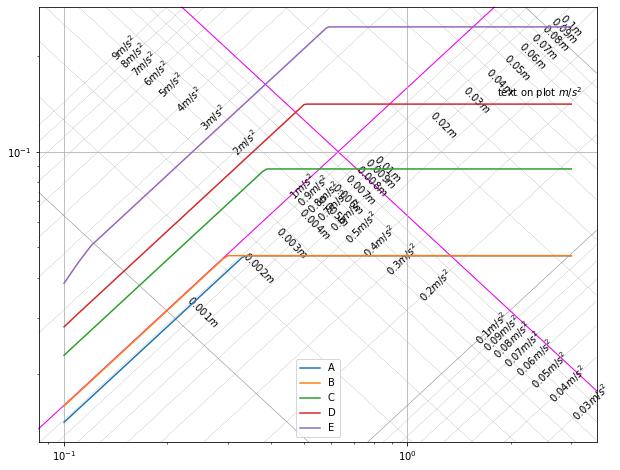

In [16]:
#

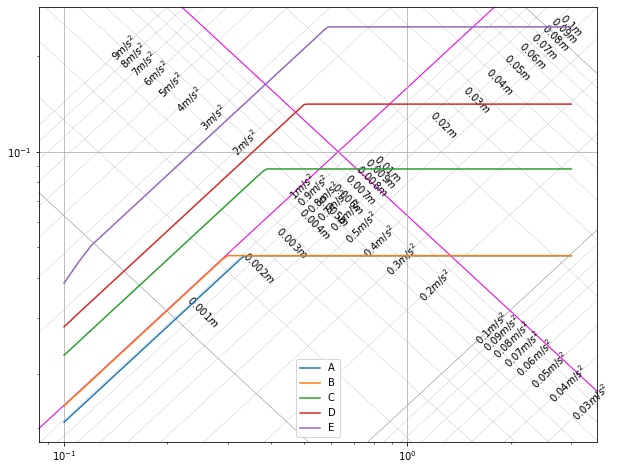

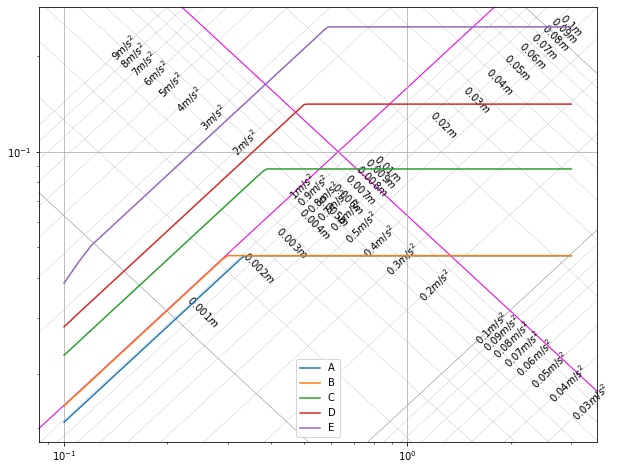

In [20]:
#ASCE41_17_tripartite_plot(S_s, S_1)

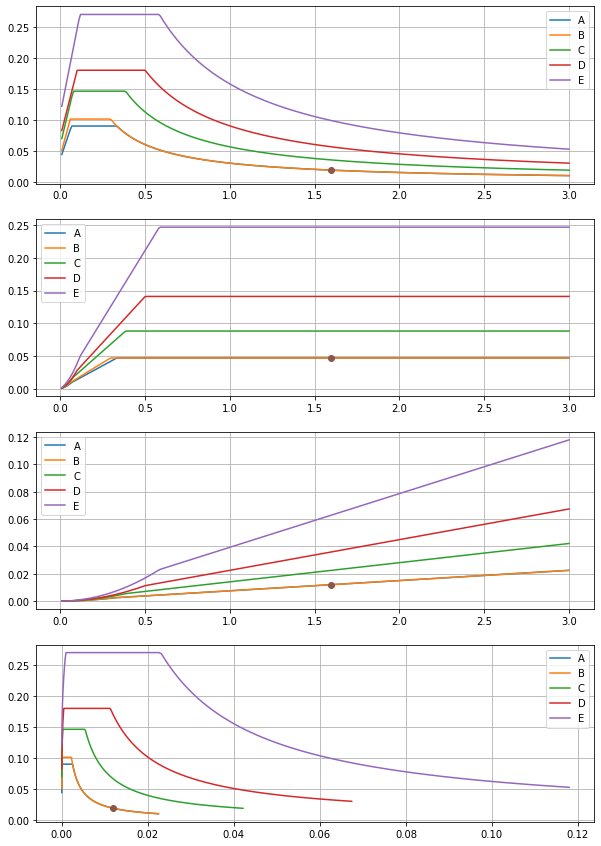

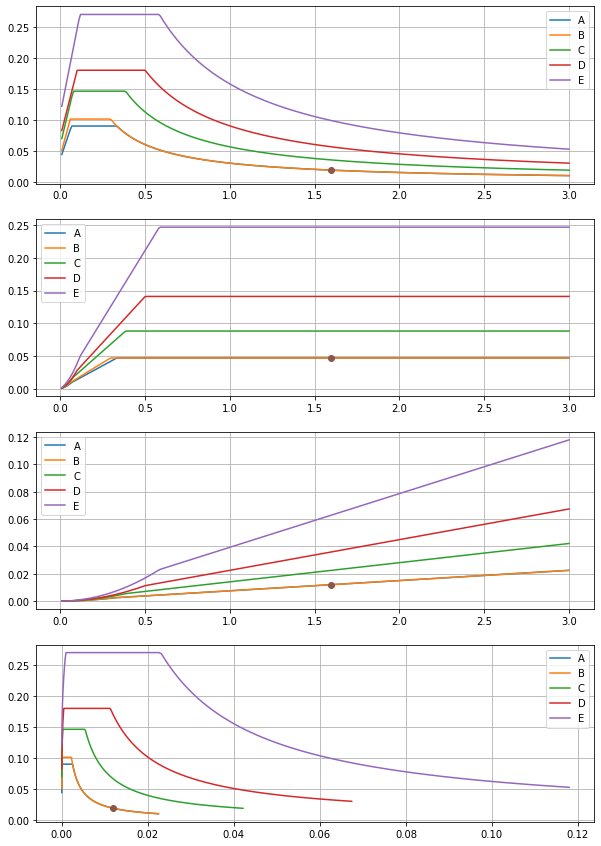

In [21]:
#ASCE41_17_plots(S_s, S_1, T_code_s)